In [1]:
import torch.nn as nn
import torch as T
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.preprocessing import MinMaxScaler
from src.pecan_dataport.participant_preprocessing import PecanParticipantPreProcessing

In [2]:
def MSEError(labels, predictions):
    return np.sum(np.diff([labels, predictions], axis=0)**2)/len(predictions)

def RMSEError(labels, predictions):
    return (MSEError(labels, predictions))**0.5

def MAEError(labels, predictions):
    return np.sum(abs(np.diff([labels, predictions], axis=0)))/len(predictions)

def MAPEError(labels, predictions):
    return np.sum(abs(np.divide(np.diff([labels, predictions], axis=0), labels)))/len(predictions)

def descale(descaler, values):
    values_2d = np.array(values)[:, np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()

def PolarPlotMaker(labels: list, values: list, polar_color:str, polar_legend: str):
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, values, color=polar_color, linewidth=1)
    # Fill it in.
    ax.fill(angles, values, color=polar_color, alpha=0.25)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles), labels)

    for label, angle in zip(ax.get_xticklabels(), angles):
        if angle in (0, np.pi):
            label.set_horizontalalignment('center')
        elif 0 < angle < np.pi:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')

    ax.set_rlabel_position(180 / num_vars)
    ax.set_title(polar_legend, y=1.08)
    plt.show()

In [3]:
pecan_dataset = PecanParticipantPreProcessing('661_test_30_pca', 'data/participants_data/1min/', 60)
default_scaler = pecan_dataset.get_scaler()

[!] - Trainable dataframe shape - (129086, 18)
[*] Train dataframe shape: (90360, 18)
[*] Validation dataframe shape: (25817, 18)
[*] Test dataframe shape: (12909, 18)


100%|█████████████████████████████████████████████████████████████████████████| 25757/25757 [00:02<00:00, 12611.92it/s]

[!] Train sequence shape: (60, 18)
[!] Val sequence shape: (60, 18)


In [4]:
with open(f'etc/results/661_test_30_pca/result_report.json') as json_file:
    data = json.load(json_file)
    json_file.close()

In [5]:
predictions_data = data 
new_prediction_data = []
new_result_data = []
for model in predictions_data:
    for prediction in model['predict']:
        prediction['model'] = model['model']
    for result in model['test']:
        result['model'] = model['model']
    new_result_data += model['test']
    new_prediction_data += model['predict']
complete_prediction_df = pd.DataFrame(new_prediction_data)
complete_result_df = pd.DataFrame(new_result_data)

In [6]:
complete_prediction_df

,label,model_output,loss,model
0,-0.531253,-0.533892,6.968074e-06,RNN
1,-0.529845,-0.533853,1.605925e-05,RNN
2,-0.527775,-0.526817,9.192980e-07,RNN
3,-0.526451,-0.526881,1.848383e-07,RNN
4,-0.525871,-0.524609,1.593570e-06,RNN
...,...,...,...,...
51391,-0.739217,-0.764751,6.519869e-04,Fusion-RNN-LSTM-GRU
51392,-0.735160,-0.757401,4.946646e-04,Fusion-RNN-LSTM-GRU
51393,-0.735243,-0.755356,4.045228e-04,Fusion-RNN-LSTM-GRU
51394,-0.741204,-0.755341,1.998556e-04,Fusion-RNN-LSTM-GRU


In [7]:
complete_result_df

,test/MAE,test/MAPE,test/SMAPE,test/WMAPE,test/MSE,test/RMSE,test/MSLE,test/test_loss,model
0,0.026051,0.161302,0.100558,0.161302,0.002855,0.026051,0.017401,0.002855,RNN
1,0.040248,0.207194,0.128130,0.207194,0.004104,0.040248,0.021818,0.004104,LSTM
2,0.029107,0.165222,0.103902,0.165222,0.003213,0.029107,0.018365,0.003213,GRU
3,0.029938,0.168928,0.106512,0.168928,0.003042,0.029938,0.017165,0.003042,Fusion-RNN-LSTM-GRU


In [8]:
calc_result = []
labels = np.array(complete_prediction_df[complete_prediction_df['model'] == 'GRU'].label)
for model in list(complete_result_df.model):
    predictions = np.array(complete_prediction_df[complete_prediction_df['model'] == model].model_output)
    calc_result.append({
        'calculate_MSE':MSEError(labels, predictions),
        'calculate_RMSE':RMSEError(labels, predictions),
        'calculate_MAE':MAEError(labels, predictions),
        'calculate_MAPE': MAPEError(labels, predictions),
        'model': model
    })
calc_result_df = pd.DataFrame(calc_result)
calc_result_df

,calculate_MSE,calculate_RMSE,calculate_MAE,calculate_MAPE,model
0,0.002855,0.053434,0.026051,0.161302,RNN
1,0.004104,0.064062,0.040248,0.207194,LSTM
2,0.003213,0.056681,0.029107,0.165222,GRU
3,0.003042,0.055153,0.029939,0.168928,Fusion-RNN-LSTM-GRU


In [9]:
gru_outputs = np.array(complete_prediction_df[complete_prediction_df['model'] == 'GRU'].model_output)
lstm_outputs = np.array(complete_prediction_df[complete_prediction_df['model'] == 'LSTM'].model_output)
rnn_outputs = np.array(complete_prediction_df[complete_prediction_df['model'] == 'RNN'].model_output)

In [10]:
ensemble_predictions = np.sum([gru_outputs, lstm_outputs, rnn_outputs], axis=0)/3
avg_ensemble_df = pd.DataFrame({'label': labels, 'model_output': ensemble_predictions, 'model':'RecorrentAvgEnsemble'})
complete_prediction_df = pd.concat([complete_prediction_df, avg_ensemble_df])

In [11]:
calc_result_df = pd.concat([calc_result_df, pd.DataFrame([{ 
    'calculate_MSE': MSEError(labels, ensemble_predictions),
    'calculate_RMSE': RMSEError(labels, ensemble_predictions),
    'calculate_MAE': MAEError(labels, ensemble_predictions),
    'calculate_MAPE': MAPEError(labels, ensemble_predictions),
    'model': 'RecorrentAvgEnsemble'
}])])
calc_result_df

,calculate_MSE,calculate_RMSE,calculate_MAE,calculate_MAPE,model
0,0.002855,0.053434,0.026051,0.161302,RNN
1,0.004104,0.064062,0.040248,0.207194,LSTM
2,0.003213,0.056681,0.029107,0.165222,GRU
3,0.003042,0.055153,0.029939,0.168928,Fusion-RNN-LSTM-GRU
0,0.003042,0.055153,0.029939,0.168928,RecorrentAvgEnsemble


In [24]:
weights = np.arange(0.01, 1.01, .05)
weights_ensemble = []
weights

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [25]:
for w1 in weights:
    for w2 in weights:
        for w3 in weights:
            ensemble_wavg_predictions = np.sum([gru_outputs * w1, lstm_outputs * w2, rnn_outputs * w3], axis=0)/(w1+w2+w3)
            data = {
                'w1': w1,
                'w2': w2,
                'w3': w3,
                'wavg_ensemble': ensemble_wavg_predictions,
                'calculate_MSE': MSEError(labels, ensemble_wavg_predictions),
                'calculate_RMSE': RMSEError(labels, ensemble_wavg_predictions),
                'calculate_MAE': MAEError(labels, ensemble_wavg_predictions),
                'calculate_MAPE': MAPEError(labels, ensemble_wavg_predictions)
            }
            weights_ensemble.append(data)

invalid value encountered in true_divide


In [14]:
w_avg = pd.DataFrame(weights_ensemble)
w_avg['calculate_MSE'].idxmin()

1462

In [15]:
w_avg[w_avg.index == w_avg['calculate_MSE'].idxmin()]

,w1,w2,w3,wavg_ensemble,calculate_MSE,calculate_RMSE,calculate_MAE,calculate_MAPE
1462,0.3,0.1,1.0,"[-0.5376939986433301, -0.5375210557665144, -0.5316647929804666, -0.5312377001558032, -0.5291978291102819, -0.5296838283538818, -0.5285240284034184, -0.5250557277883802, -0.5335404234273093, -0.5419141394751413, -0.5378651193210057, -0.5365572401455471, -0.5349067279270717, -0.53257668869836, -0.530286682503564, -0.5264707590852465, -0.5243561821324485, -0.5225642706666674, -0.5203266058649336, -0.5179666578769684, -0.5146976624216353, -0.5128614008426667, -0.5125690741198404, -0.5108552489961897, -0.4903839081525803, -0.43907456738608225, -0.4548042565584183, -0.45619413469518943, -0.45407...",0.002839,0.053283,0.026746,0.160753


In [16]:
best_enseble = w_avg.iloc[w_avg['calculate_MSE'].idxmin(),:]
w_avg_prediction = best_enseble['wavg_ensemble']
w_avg_ensemble_df = pd.DataFrame({'label': labels, 'model_output': w_avg_prediction, 'model':'WeightedRecorrentAvgEnsemble'})
complete_prediction_df = pd.concat([complete_prediction_df, w_avg_ensemble_df])

In [17]:
calc_result_df = pd.concat([calc_result_df, pd.DataFrame([{ 
    'calculate_MSE': best_enseble['calculate_MSE'],
    'calculate_RMSE': best_enseble['calculate_RMSE'],
    'calculate_MAE': best_enseble['calculate_MAE'],
    'calculate_MAPE': best_enseble['calculate_MAPE'],
    'model': 'WAvgRecorrentAvgEnsemble'
}])])
calc_result_df

,calculate_MSE,calculate_RMSE,calculate_MAE,calculate_MAPE,model
0,0.002855,0.053434,0.026051,0.161302,RNN
1,0.004104,0.064062,0.040248,0.207194,LSTM
2,0.003213,0.056681,0.029107,0.165222,GRU
3,0.003042,0.055153,0.029939,0.168928,Fusion-RNN-LSTM-GRU
0,0.003042,0.055153,0.029939,0.168928,RecorrentAvgEnsemble
0,0.002839,0.053283,0.026746,0.160753,WAvgRecorrentAvgEnsemble


In [18]:
fusion_outputs = np.array(complete_prediction_df[complete_prediction_df['model'] == 'Fusion-RNN-LSTM-GRU'].model_output)

['RNN', 'LSTM', 'GRU', 'Fusion-RNN-LSTM-GRU', 'RecorrentAvgEnsemble', 'WAvgRecorrentAvgEnsemble']


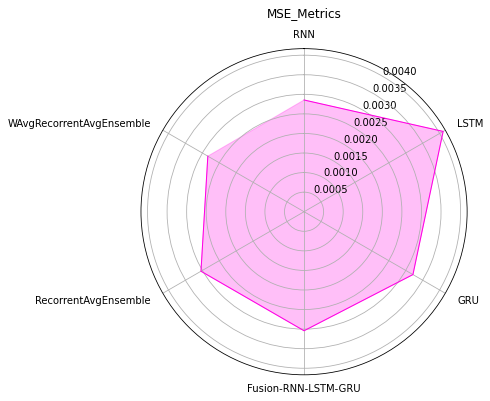

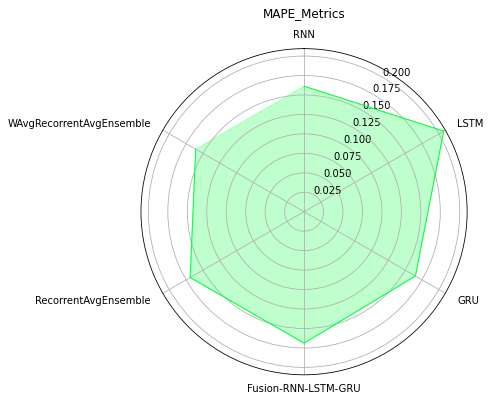

In [19]:
models_labels = calc_result_df['model'].tolist()
print(models_labels)
MSE_Values = calc_result_df['calculate_MSE'].tolist()
PolarPlotMaker(models_labels, MSE_Values, '#FF00E4', 'MSE_Metrics')

MAPE_Values = calc_result_df['calculate_MAPE'].tolist()
PolarPlotMaker(models_labels, MAPE_Values, '#00FF3E', 'MAPE_Metrics')

In [20]:
descaler = MinMaxScaler()
descaler.min_, descaler.scale_ = default_scaler.min_[-1], default_scaler.scale_[-1]

In [21]:
descaled_fusion_recorrent = descale(descaler, fusion_outputs)
descaled_w_avg_ensemble_prediction = descale(descaler, w_avg_prediction)
descaled_avg_ensemble_prediction = descale(descaler, ensemble_predictions)
descaled_rnn_prediction = descale(descaler, rnn_outputs)
descaled_gru_prediction = descale(descaler, gru_outputs)
descaled_lstm_prediction = descale(descaler, lstm_outputs)
descaled_label = descale(descaler, labels)

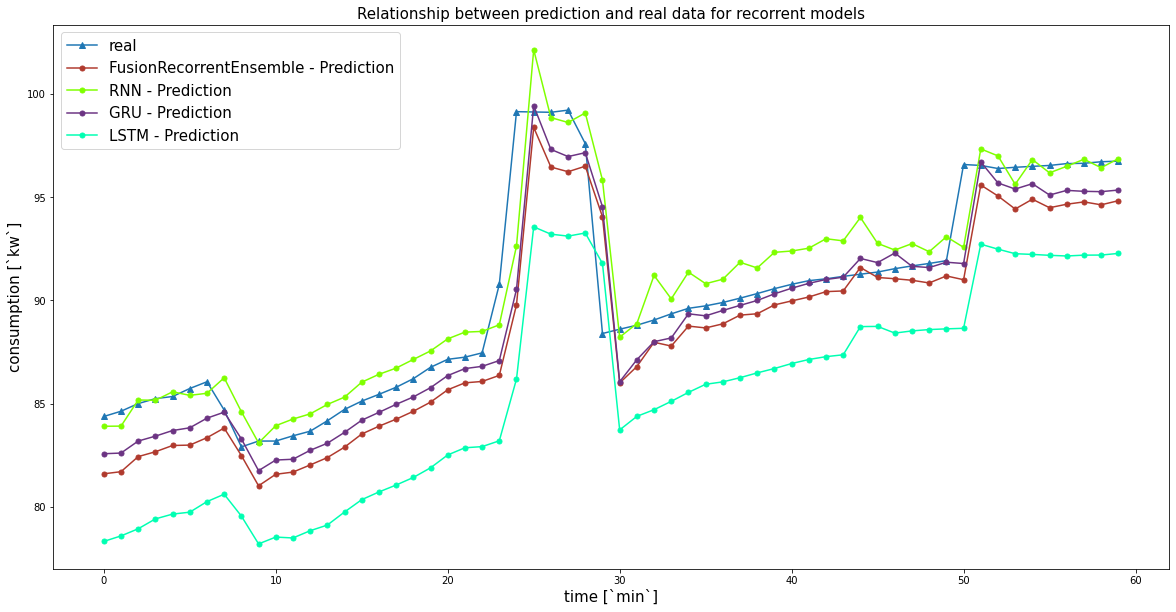

In [22]:
plt.figure(figsize=(20, 10))
plt.title(f'Relationship between prediction and real data for recorrent models', fontsize=15)
plt.plot(descaled_label[:60], '^', ls='-',label='real')
plt.plot(descaled_fusion_recorrent[:60], '.', ms = 10, ls = '-', c = '#B03A2E',label='FusionRecorrentEnsemble - Prediction')
plt.plot(descaled_rnn_prediction[:60], '.', ms = 10, ls = '-', c = '#7FFF00',label='RNN - Prediction')
plt.plot(descaled_gru_prediction[:60], '.', ms = 10, ls = '-', c = '#6C3483',label='GRU - Prediction')
plt.plot(descaled_lstm_prediction[:60], '.', ms = 10, ls = '-', c = '#00FFB2',label='LSTM - Prediction')



# plt.plot(output, 'm--', label='predictions')

plt.xlabel('time [`min`]', fontsize=15)
plt.ylabel('consumption [`kw`]', fontsize=15)
plt.legend(fontsize=15)
# plt.savefig(f'methodology/imgs/results/forecasting/others_models_forecasting.eps', dpi=600, bbox_inches='tight')
# plt.savefig(f'methodology/imgs/results/forecasting/others_models_forecasting.svg', dpi=600, bbox_inches='tight')
plt.show()

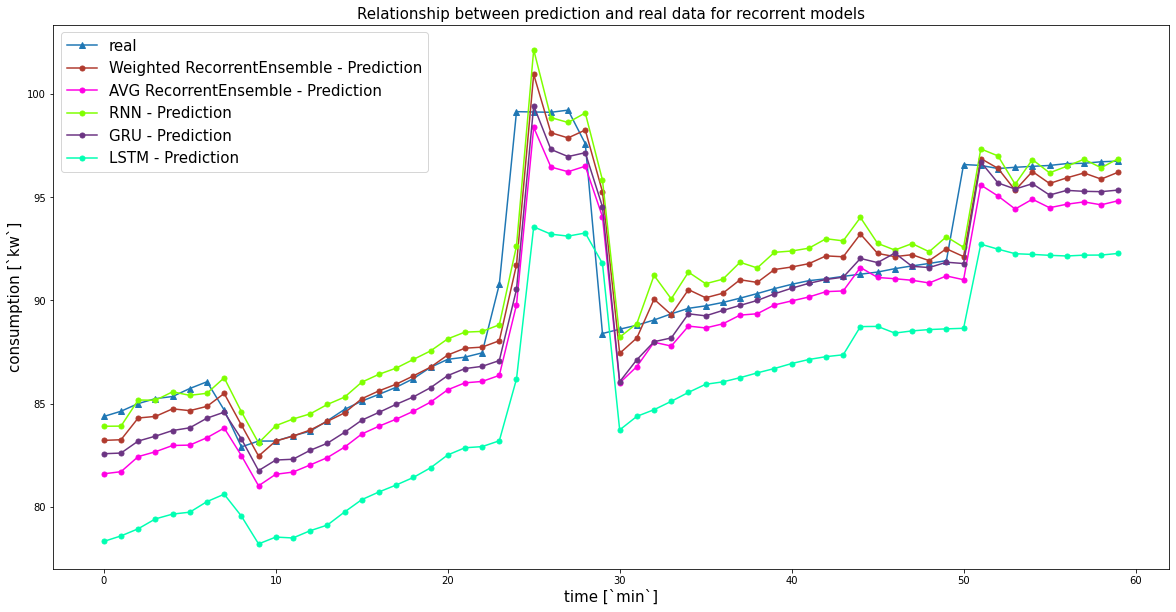

In [23]:
plt.figure(figsize=(20, 10))
plt.title(f'Relationship between prediction and real data for recorrent models', fontsize=15)
plt.plot(descaled_label[:60], '^', ls='-',label='real')
plt.plot(descaled_w_avg_ensemble_prediction[:60], '.', ms = 10, ls = '-', c = '#B03A2E',label='Weighted RecorrentEnsemble - Prediction')
plt.plot(descaled_avg_ensemble_prediction[:60], '.', ms = 10, ls = '-', c = '#FF00E4',label='AVG RecorrentEnsemble - Prediction')
plt.plot(descaled_rnn_prediction[:60], '.', ms = 10, ls = '-', c = '#7FFF00',label='RNN - Prediction')
plt.plot(descaled_gru_prediction[:60], '.', ms = 10, ls = '-', c = '#6C3483',label='GRU - Prediction')
plt.plot(descaled_lstm_prediction[:60], '.', ms = 10, ls = '-', c = '#00FFB2',label='LSTM - Prediction')



# plt.plot(output, 'm--', label='predictions')

plt.xlabel('time [`min`]', fontsize=15)
plt.ylabel('consumption [`kw`]', fontsize=15)
plt.legend(fontsize=15)
# plt.savefig(f'methodology/imgs/results/forecasting/others_models_forecasting.eps', dpi=600, bbox_inches='tight')
# plt.savefig(f'methodology/imgs/results/forecasting/others_models_forecasting.svg', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
plt.title(f'Loss', fontsize=15)
plt.plot(complete_prediction_df[complete_prediction_df['model'] == 'GRU'].loss)


# plt.plot(output, 'm--', label='predictions')

plt.xlabel('Index', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(fontsize=15)
# plt.savefig(f'methodology/imgs/results/forecasting/others_models_forecasting.eps', dpi=600, bbox_inches='tight')
# plt.savefig(f'methodology/imgs/results/forecasting/others_models_forecasting.svg', dpi=600, bbox_inches='tight')
plt.show()
